In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms 
from torch.utils.data import DataLoader,Subset
import numpy as np
from torch import nn
import math
import torch.nn.functional as F
import torchvision.datasets as datasets

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [2]:
transform = transforms.Compose([
    transforms.Resize(28),                 # (MNIST is already 28x28; crop not needed)
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),       # FIX: train in [-1,1] for DDPM stability
])

data=datasets.MNIST(root="C:/Users/maddo/Downloads/COdes from Work/Working on now",train=True,download=True,transform=transform)

In [3]:
#data = datasets.CelebA(root="C:/Users/maddo/Downloads/COdes from Work/Working on now",split='train',target_type='attr',download=True,transform=transform)

In [4]:
len(data)

60000

In [5]:
train_loader=DataLoader(data,batch_size=32, shuffle=True)

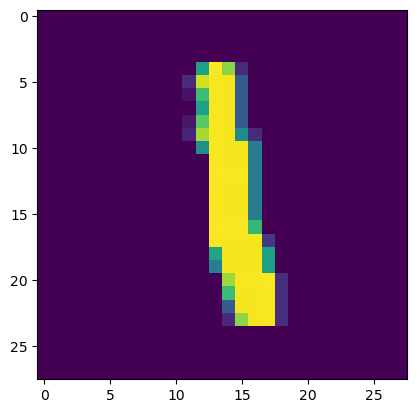

In [6]:

plt.imshow(data[6][0].permute(1,2,0))

T=300
beta = torch.linspace(1e-4, 0.046,T)
alpha = 1.0 - beta
alphacum = torch.cumprod(alpha, dim=0) 
sqrtalphacum=torch.sqrt(alphacum)
minsqrtalphacum=torch.sqrt(1-alphacum)
alphacum_prev = torch.cat([torch.tensor([1.0]), alphacum[:-1]], dim=0) 

In [7]:
def make_cosine_beta(T, s=0.008, device=None):
    steps = torch.arange(T+1, dtype=torch.float32, device=device)
    f = torch.cos(((steps / T + s) / (1 + s)) * torch.pi / 2) ** 2
    alpha_bar = f / f[0]                     # ᾱ_t
    betas = 1.0 - (alpha_bar[1:] / alpha_bar[:-1])
    return betas.clamp(1e-5, 0.999)

In [8]:
device='cuda'
T=500
beta = make_cosine_beta(T, device=device)
alpha = 1.0 - beta
alphacum = torch.cumprod(alpha, dim=0)
sqrtalphacum = torch.sqrt(alphacum)
minsqrtalphacum = torch.sqrt(1 - alphacum)
alphacum_prev = torch.cat([torch.tensor([1.0], device=device), alphacum[:-1]], dim=0)

print('alpha_cum_end =', float(alphacum[-1])) 

alpha_cum_end = 9.714315574171906e-09


In [9]:
def noisyimagetest(img,timestep,eps):
    mul=sqrtalphacum[timestep].to('cuda')
    epsmul=minsqrtalphacum[timestep].to('cuda')
    print(mul)
    mul = mul[:, None, None, None]
    epsmul = epsmul[:, None, None, None]
    img=img.to('cuda')
    eps=eps.to('cuda')
    noisy=(img*mul+eps*epsmul).to('cuda')
    plt.subplot(4,1,1)
    plt.figsize=(10,19)
    plt.imshow(noisy[0].to('cpu').permute(1,2,0))
    plt.subplot(4,1,2)
    plt.imshow(noisy[1].to('cpu').permute(1,2,0))
    plt.subplot(4,1,3)
    plt.imshow(noisy[3].to('cpu').permute(1,2,0))
    plt.subplot(4,1,4)
    plt.imshow(noisy[4].to('cpu').permute(1,2,0))
    
    #return noisy
    

In [10]:
def noisyimage(img, timestep, eps):
    # img: (B,1,28,28), timestep: (B,), eps: like img
    mul    = sqrtalphacum.to(img.device)[timestep]       # FIX: ensure same device
    epsmul = minsqrtalphacum.to(img.device)[timestep]    # FIX: ensure same device
    mul    = mul[:, None, None, None]
    epsmul = epsmul[:, None, None, None]
    noisy  = img * mul + eps * epsmul
    return noisy

tensor([0.9998, 0.9998, 0.9998, 0.9999, 0.9998, 0.9998, 0.9998, 0.9999, 0.9998,
        0.9998, 0.9999, 0.9998, 0.9998, 0.9998, 0.9999, 0.9999, 0.9999, 0.9998,
        0.9998, 0.9998, 0.9999, 0.9998, 0.9998, 0.9999, 0.9998, 0.9998, 0.9998,
        0.9998, 0.9998, 0.9998, 0.9998, 0.9999], device='cuda:0')
tensor([0.9998, 0.9998, 0.9998, 0.9999, 0.9998, 0.9998, 0.9998, 0.9999, 0.9998,
        0.9998, 0.9999, 0.9998, 0.9998, 0.9998, 0.9999, 0.9999, 0.9999, 0.9998,
        0.9998, 0.9998, 0.9999, 0.9998, 0.9998, 0.9999, 0.9998, 0.9998, 0.9998,
        0.9998, 0.9998, 0.9998, 0.9998, 0.9999], device='cuda:0')
tensor([0.9998, 0.9998, 0.9998, 0.9999, 0.9998, 0.9998, 0.9998, 0.9999, 0.9998,
        0.9998, 0.9999, 0.9998, 0.9998, 0.9998, 0.9999, 0.9999, 0.9999, 0.9998,
        0.9998, 0.9998, 0.9999, 0.9998, 0.9998, 0.9999, 0.9998, 0.9998, 0.9998,
        0.9998, 0.9998, 0.9998, 0.9998, 0.9999], device='cuda:0')


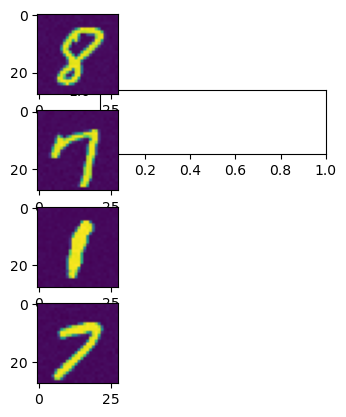

In [11]:
for x,_ in train_loader:
    times=torch.randint(1,3,(len(x),))
    eps=torch.randn_like(x)
    #print(eps.shape)
    plt.subplot(5,2,4)
    noisyimagetest(x,times,eps)
    noisyimagetest(x,times,eps)
    noisyimagetest(x,times,eps)
    break

In [12]:
def timestep_embedding(t, dim=64, max_period=10000):
    # t in [0, T-1] integer or float; returns (B, dim)
    if t.dtype != torch.float32:
        t = t.float()
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(0, half, device=t.device).float() / half
    )  # (half,)
    args = t[:, None] * freqs[None, :]  # (B, half)
    emb = torch.cat([torch.cos(args), torch.sin(args)], dim=1)
    if dim % 2:  # odd
        emb = F.pad(emb, (0,1))
    return emb

In [13]:
class noisepredict(nn.Module):
    def __init__(self, emb_dim=64, base=64):
        super().__init__()
        self.emb_dim = emb_dim
        self.base = base

        # ---- time MLP (no Sequential) -> produce per-block biases (3 * base)
        self.tfc1 = nn.Linear(emb_dim, 128)
        self.tact = nn.SiLU()
        self.tfc2 = nn.Linear(128, base * 3)

        # ---- stem
        self.inp_conv = nn.Conv2d(1, base, kernel_size=3, padding=1)

        # ---- Block 1 (residual), no Sequential
        self.b1_c1 = nn.Conv2d(base, base, 3, padding=1)
        self.b1_g1 = nn.GroupNorm(8, base)
        self.b1_a1 = nn.SiLU()
        self.b1_c2 = nn.Conv2d(base, base, 3, padding=1)
        self.b1_g2 = nn.GroupNorm(8, base)
        self.b1_a2 = nn.SiLU()

        # ---- Block 2
        self.b2_c1 = nn.Conv2d(base, base, 3, padding=1)
        self.b2_g1 = nn.GroupNorm(8, base)
        self.b2_a1 = nn.SiLU()
        self.b2_c2 = nn.Conv2d(base, base, 3, padding=1)
        self.b2_g2 = nn.GroupNorm(8, base)
        self.b2_a2 = nn.SiLU()

        # ---- Block 3
        self.b3_c1 = nn.Conv2d(base, base, 3, padding=1)
        self.b3_g1 = nn.GroupNorm(8, base)
        self.b3_a1 = nn.SiLU()
        self.b3_c2 = nn.Conv2d(base, base, 3, padding=1)
        self.b3_g2 = nn.GroupNorm(8, base)
        self.b3_a2 = nn.SiLU()

        # ---- head
        self.out_conv = nn.Conv2d(base, 1, kernel_size=3, padding=1)

    def _time_biases(self, t):
        # t: (B,)
        emb = timestep_embedding(t.float(), dim=self.emb_dim)   # (B, emb_dim)
        h = self.tfc1(emb);  h = self.tact(h);  h = self.tfc2(h)  # (B, 3*base)
        b1, b2, b3 = h.split(self.base, dim=1)                   # each (B, base)
        # reshape to (B, C, 1, 1) for broadcasting
        return b1[:, :, None, None], b2[:, :, None, None], b3[:, :, None, None]

    def forward(self, x, t):
        # x: (B,1,28,28), t: (B,)
        b1_bias, b2_bias, b3_bias = self._time_biases(t)

        h = self.inp_conv(x)

        # ---- Block 1 (residual)
        identity = h
        h = self.b1_c1(h + b1_bias); h = self.b1_g1(h); h = self.b1_a1(h)
        h = self.b1_c2(h);           h = self.b1_g2(h); h = self.b1_a2(h)
        h = h + identity

        # ---- Block 2 (residual)
        identity = h
        h = self.b2_c1(h + b2_bias); h = self.b2_g1(h); h = self.b2_a1(h)
        h = self.b2_c2(h);           h = self.b2_g2(h); h = self.b2_a2(h)
        h = h + identity

        # ---- Block 3 (residual)
        identity = h
        h = self.b3_c1(h + b3_bias); h = self.b3_g1(h); h = self.b3_a1(h)
        h = self.b3_c2(h);           h = self.b3_g2(h); h = self.b3_a2(h)
        h = h + identity

        return self.out_conv(h)

In [14]:
enc=noisepredict()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
enc = enc.to(device)
optim = torch.optim.AdamW(enc.parameters(), lr=2e-5, betas=(0.9, 0.999), weight_decay=0.0)
criterion = nn.MSELoss()

epoch=600

In [15]:
for i in range(epoch):
    oneofus=0
    enc.train()
    ma = 0.0
    count = 0
    for x,_ in train_loader:
        times=torch.randint(0,T,(len(x),)).to(device)
        eps=torch.randn(len(x),1,28,28).to(device)
        x=x.to(device)
        x_time=noisyimage(x,times,eps)
        pred=enc(x_time,times)
        optim.zero_grad()
        loss=criterion(pred,eps)
        #print(loss.item())
        loss.backward()
        optim.step()
        oneofus=loss.item()
        count += 1
        ma += (loss.item() - ma) / count
    if i%2==0:
        print(f" For Epoch number {i} Loss is currently {ma}")#
        
        

        
        
    

 For Epoch number 0 Loss is currently 0.14377994223237026
 For Epoch number 2 Loss is currently 0.06198765553434691
 For Epoch number 4 Loss is currently 0.05482315926253806
 For Epoch number 6 Loss is currently 0.05184989758928611
 For Epoch number 8 Loss is currently 0.05003390813867245
 For Epoch number 10 Loss is currently 0.04898683141171931
 For Epoch number 12 Loss is currently 0.047881766631205955
 For Epoch number 14 Loss is currently 0.0470169105052948
 For Epoch number 16 Loss is currently 0.046601493247350016
 For Epoch number 18 Loss is currently 0.04609499609271689
 For Epoch number 20 Loss is currently 0.04582853967448074
 For Epoch number 22 Loss is currently 0.04521573589344816
 For Epoch number 24 Loss is currently 0.04482951531608896
 For Epoch number 26 Loss is currently 0.044619927898049354
 For Epoch number 28 Loss is currently 0.04402900435229155
 For Epoch number 30 Loss is currently 0.0442389396727085
 For Epoch number 32 Loss is currently 0.04408069532016917
 

KeyboardInterrupt: 

In [16]:
def sample(model, x_t, t, out_dir="samples", prefix="ddpm", save_grid=True, nrow=6):
    """
    Runs the full DDPM reverse process from T-1 -> 0 and saves images to disk.

    Args:
        model: noise predictor ε_θ
        x_t:   starting noise (B,1,28,28)
        t:     ignored (kept for signature compatibility)
        out_dir: directory to save images
        prefix: filename prefix
        save_grid: also save a grid image
        nrow: columns for the grid
    """
    model.eval()
    os.makedirs(out_dir, exist_ok=True)

    x_t = x_t.to(device)
    B = x_t.size(0)

    for step in reversed(range(T)):                      # FULL chain
        t_long = torch.full((B,), step, dtype=torch.long, device=x_t.device)

        # Gather scalars (B,1,1,1)
        alpha_t        = alpha.to(x_t.device)[t_long].view(B,1,1,1)
        alpha_hat_t    = alphacum.to(x_t.device)[t_long].view(B,1,1,1)
        beta_t         = beta.to(x_t.device)[t_long].view(B,1,1,1)
        alpha_hat_prev = alphacum_prev.to(x_t.device)[t_long].view(B,1,1,1)

        # Predict noise
        eps = model(x_t, t_long)

        # DDPM mean
        mean = (x_t - ((1.0 - alpha_t) / torch.sqrt(1.0 - alpha_hat_t)) * eps) / torch.sqrt(alpha_t)

        # DDPM variance
        var   = (1.0 - alpha_hat_prev) / (1.0 - alpha_hat_t) * beta_t
        sigma = torch.sqrt(torch.clamp(var, min=1e-20))

        # No noise at t=0
        z = torch.randn_like(x_t)
        nonzero = (t_long > 0).float().view(B,1,1,1)
        x_t = mean + nonzero * sigma * z

    # map [-1,1] -> [0,1]
    out = x_t.clamp(-1, 1)
    out = (out + 1) / 2.0  # (B,1,28,28), float in [0,1]

    # Save individual samples
    for i in range(B):
        torchvision.utils.save_image(out[i], os.path.join(out_dir, f"{prefix}_{i:03d}.png"))

    # Also save a grid (optional)
    if save_grid:
        grid = torchvision.utils.make_grid(out, nrow=min(nrow, B), padding=2)
        torchvision.utils.save_image(grid, os.path.join(out_dir, f"{prefix}_grid.png"))

    return out

for _ in range(2):
    newsamples = torch.randn(6, 3, 64, 64)
    tsamples   = torch.full((newsamples.size(0),), 1, dtype=torch.long)  # (B,) long
    sample(enc, newsamples, tsamples)

In [17]:
import os
import torchvision

In [18]:
for _ in range(2):
    newsamples = torch.randn(10, 1, 28, 28, device=device)                      # start from noise
    tsamples   = torch.full((newsamples.size(0),), T-1, dtype=torch.long, device=device)
    sample(enc, newsamples, tsamples)    